In [5]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


Iso contour implementation using Cython with a insertion algorithm to merge polygons together. The image is split into several blocks to find local iso contours. The result is finally merge all together. This way allow a full OpenMP optimization.

MarchingSquareCythonInsertOpenMp
================================

In [40]:
%%cython --cplus --compile-args=-std=c++11 --compile-args=-fopenmp --link-args=-fopenmp --force -a

import numpy
cimport numpy as cnumpy

from libcpp.vector cimport vector
from libcpp.list cimport list as clist
from libcpp cimport bool
from libc.math cimport fabs

from cython.parallel import prange
from cython.operator cimport dereference
from cython.operator cimport preincrement
cimport cython

# from libcpp.unordered_map cimport unordered_map
from libcpp.utility cimport pair
cdef extern from "<unordered_map>" namespace "std" nogil:
    cdef cppclass unordered_map[T, U]:
        ctypedef T key_type
        ctypedef U mapped_type
        ctypedef pair[const T, U] value_type
        cppclass iterator:
            pair[T, U]& operator*()
            iterator operator++()
            iterator operator--()
            bint operator==(iterator)
            bint operator!=(iterator)
        cppclass reverse_iterator:
            pair[T, U]& operator*()
            iterator operator++()
            iterator operator--()
            bint operator==(reverse_iterator)
            bint operator!=(reverse_iterator)
        cppclass const_iterator(iterator):
            pass
        cppclass const_reverse_iterator(reverse_iterator):
            pass
        unordered_map() except +
        unordered_map(unordered_map&) except +
        #unordered_map(key_compare&)
        U& operator[](T&)
        #unordered_map& operator=(unordered_map&)
        bint operator==(unordered_map&, unordered_map&)
        bint operator!=(unordered_map&, unordered_map&)
        bint operator<(unordered_map&, unordered_map&)
        bint operator>(unordered_map&, unordered_map&)
        bint operator<=(unordered_map&, unordered_map&)
        bint operator>=(unordered_map&, unordered_map&)
        U& at(T&)
        iterator begin()
        const_iterator const_begin "begin"()
        void clear()
        size_t count(T&)
        bint empty()
        iterator end()
        const_iterator const_end "end"()
        pair[iterator, iterator] equal_range(T&)
        #pair[const_iterator, const_iterator] equal_range(key_type&)
        iterator erase(iterator)
        iterator erase(iterator, iterator)
        size_t erase(T&)
        iterator find(T&)
        const_iterator const_find "find"(T&)
        pair[iterator, bint] insert(pair[T, U]) # XXX pair[T,U]&
        iterator insert(iterator, pair[T, U]) # XXX pair[T,U]&
        #void insert(input_iterator, input_iterator)
        #key_compare key_comp()
        iterator lower_bound(T&)
        const_iterator const_lower_bound "lower_bound"(T&)
        size_t max_size()
        reverse_iterator rbegin()
        const_reverse_iterator const_rbegin "rbegin"()
        reverse_iterator rend()
        const_reverse_iterator const_rend "rend"()
        size_t size()
        void swap(unordered_map&)
        iterator upper_bound(T&)
        const_iterator const_upper_bound "upper_bound"(T&)
        #value_compare value_comp()
        void max_load_factor(float)
        float max_load_factor()
        void reserve(size_t)
        size_t bucket_count()


cdef double EPSILON = numpy.finfo(numpy.float64).eps

cdef cnumpy.int8_t[2] *EDGE_TO_POINT = [[0, 0], [1, 0], [1, 1], [0, 1], [0, 0]]
cdef cnumpy.int8_t[5] *CELL_TO_EDGE = [
                                       # array of index containing
                                       # id0: number of segments (up to 2)
                                       # id1: index of the start of the 1st edge
                                       # id2: index of the end of the 1st edge
                                       # id3: index of the start of the 2nd edge
                                       # id4: index of the end of the 2nd edge
                                       [0, 0, 0, 0, 0],  # Case 0: 0000: nothing
                                       [1, 0, 3, 0, 0],  # Case 1: 0001
                                       [1, 0, 1, 0, 0],  # Case 2: 0010
                                       [1, 1, 3, 0, 0],  # Case 3: 0011

                                       [1, 1, 2, 0, 0],  # Case 4: 0100
                                       [2, 0, 1, 2, 3],  # Case 5: 0101 > ambiguous
                                       [1, 0, 2, 0, 0],  # Case 6: 0110
                                       [1, 2, 3, 0, 0],  # Case 7: 0111

                                       [1, 2, 3, 0, 0],  # Case 8: 1000
                                       [1, 0, 2, 0, 0],  # Case 9: 1001
                                       [2, 0, 3, 1, 2],  # Case 10: 1010 > ambiguous
                                       [1, 1, 2, 0, 0],  # Case 11: 1011

                                       [1, 1, 3, 0, 0],  # Case 12: 1100
                                       [1, 0, 1, 0, 0],  # Case 13: 1101
                                       [1, 0, 3, 0, 0],  # Case 14: 1110
                                       [0, 0, 0, 0, 0],  # Case 15: 1111
                                      ]

ctypedef cnumpy.int64_t hash_index_t

cdef struct point_t:
    cnumpy.float32_t x
    cnumpy.float32_t y

cdef cppclass polygon_description_t:
    hash_index_t begin
    hash_index_t end
    clist[point_t] points

    polygon_description_t() nogil:
        pass

cdef cppclass TileContext_t:
    int pos_x
    int pos_y
    int dim_x
    int dim_y

    clist[polygon_description_t*] final_polygons

    unordered_map[hash_index_t, polygon_description_t*] polygons

    TileContext_t() nogil:
        pass


cdef class MarchingSquareCythonInsertOpenMp(object):
    """Marching square using an insertion algorithm to reconstruct polygons
    on the fly while iterating input data.
    """

    cdef cnumpy.float32_t[:, :] _image
    cdef cnumpy.int8_t[:, :] _mask

    cdef cnumpy.float32_t *_image_ptr
    cdef cnumpy.int8_t *_mask_ptr
    cdef int _dim_x
    cdef int _dim_y
    cdef int _group_size
    cdef int _group_mode
    cdef bool _use_reverse
    """Check influence of the reverse function.
    If false, the result is not valid."""
    cdef bool _use_minmax_cache

    cdef TileContext_t* _final_context
    
    cdef cnumpy.float32_t[:, :] _min_cache
    cdef cnumpy.float32_t[:, :] _max_cache

    def __init__(self,
                 image, mask=None,
                 openmp_group_mode="tile",
                 openmp_group_size=256,
                 use_reverse=True,
                 use_minmax_cache=False):
        self._image = numpy.ascontiguousarray(image, numpy.float32)
        self._image_ptr = &self._image[0][0]
        if mask is not None:
            assert(image.shape == mask.shape)
            self._mask = numpy.ascontiguousarray(mask, numpy.int8)
            self._mask_ptr = &self._mask[0][0]
        else:
            self._mask = None
            self._mask_ptr = NULL
        self._group_mode = {"tile": 0, "row": 1, "col": 2}[openmp_group_mode]
        self._group_size = openmp_group_size
        self._use_reverse = use_reverse
        self._use_minmax_cache = use_minmax_cache
        if self._use_minmax_cache:
            self._min_cache = None
            self._max_cache = None
        with nogil:
            self._dim_y = self._image.shape[0]
            self._dim_x = self._image.shape[1]

    def _get_minmax_block(self, array, block_size):
        """Python code to compute min/max cache per block of an image"""
        if block_size == 0:
            return None
        size = numpy.array(array.shape)
        size = size // block_size + (size % block_size > 0)
        min_per_block = numpy.empty(size, dtype=numpy.float32)
        max_per_block = numpy.empty(size, dtype=numpy.float32)
        for y in range(size[1]):
            yend = (y + 1) * block_size
            if y + 1 == size[1]:
                yy = slice(y * block_size, array.shape[1])
            else:
                yy = slice(y * block_size, yend)
            for x in range(size[0]):
                xend = (x + 1) * block_size
                if xend > size[0]:
                    xx = slice(x * block_size, array.shape[0])
                else:
                    xx = slice(x * block_size, xend)
                min_per_block[x, y] = numpy.min(array[xx, yy])
                max_per_block[x, y] = numpy.max(array[xx, yy])
        return (min_per_block, max_per_block, block_size)

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef void _marching_squares(self, cnumpy.float64_t isovalue):
        cdef:
            int x, y, i
            vector[TileContext_t*] contexts
            TileContext_t *context
            int dim_x, dim_y
            int ix, iy

        if self._group_mode == 0:
            iy = 0
            for y in range(0, self._dim_y - 1, self._group_size):
                ix = 0
                for x in range(0, self._dim_x - 1, self._group_size):
                    if self._use_minmax_cache:
                        if isovalue < self._min_cache[iy, ix] or isovalue > self._max_cache[iy, ix]:
                            ix += 1
                            continue
                    context = self._create_context(x, y, self._group_size, self._group_size)
                    contexts.push_back(context)
                    ix += 1
                iy += 1
        elif self._group_mode == 1:
            # row
            for y in range(0, self._dim_y - 1, self._group_size):
                context = self._create_context(0, y, self._dim_x - 1, self._group_size)
                contexts.push_back(context)
        elif self._group_mode == 2:
            # col
            for x in range(0, self._dim_x - 1, self._group_size):
                context = self._create_context(x, 0, self._group_size, self._dim_y - 1)
                contexts.push_back(context)
        else:
            # FIXME: Good to add check
            pass

        if contexts.size() == 0:
            # shortcut
            self._final_context = new TileContext_t()
            return

        # openmp
        for i in prange(contexts.size(), nogil=True):
            self._marching_squares_mp(contexts[i], isovalue)

        if contexts.size() == 1:
            # shortcut
            self._final_context = contexts[0]
            return

        # merge
        self._final_context = new TileContext_t()
        self._final_context.polygons.reserve(self._dim_x * 2 + self._dim_y * 2)
        for i in range(contexts.size()):
            self._merge_context(self._final_context, contexts[i])
            del contexts[i]

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef TileContext_t *_create_context(self, int x, int y, int dim_x, int dim_y) nogil:
        cdef:
            TileContext_t *context
        context = new TileContext_t()
        context.pos_x = x
        context.pos_y = y
        context.dim_x = dim_x
        context.dim_y = dim_y
        if x + context.dim_x > self._dim_x - 1:
            context.dim_x = self._dim_x - 1 - x
        if y + context.dim_y > self._dim_y - 1:
            context.dim_y = self._dim_y - 1 - y
        if context.dim_x <= 0 or context.dim_y <= 0:
            del context
            return NULL
        return context

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef void _marching_squares_mp(self, TileContext_t *context, cnumpy.float64_t isovalue) nogil:
        cdef:
            int x, y, index
            cnumpy.float64_t tmpf
            cnumpy.float32_t *_image_ptr
            cnumpy.int8_t *_mask_ptr
            vector[TileContext_t*] contexts
            int dim_x, dim_y
            int bucket_count

        context.polygons.reserve(context.dim_x * 2 + context.dim_y * 2)
        bucket_count = context.polygons.bucket_count()
        _image_ptr = self._image_ptr + (context.pos_y * self._dim_x + context.pos_x)
        if self._mask_ptr != NULL:
            _mask_ptr = self._mask_ptr + (context.pos_y * self._dim_x + context.pos_x)
        else:
            _mask_ptr = NULL

        for y in range(context.pos_y, context.pos_y + context.dim_y):
            for x in range(context.pos_x, context.pos_x + context.dim_x):
                # Calculate index.
                index = 0
                if _image_ptr[0] > isovalue:
                    index += 1
                if _image_ptr[1] > isovalue:
                    index += 2
                if _image_ptr[self._dim_x] > isovalue:
                    index += 8
                if _image_ptr[self._dim_x + 1] > isovalue:
                    index += 4

                # Resolve ambiguity
                if index == 5 or index == 10:
                    # Calculate value of cell center (i.e. average of corners)
                    tmpf = 0.25 * (_image_ptr[0] +
                                   _image_ptr[1] +
                                   _image_ptr[self._dim_x] +
                                   _image_ptr[self._dim_x + 1])
                    # If below isovalue, swap
                    if tmpf <= isovalue:
                        if index == 5:
                            index = 10
                        else:
                            index = 5

                # Cache mask information
                if _mask_ptr != NULL:
                    _mask_ptr += 1
                    if _mask_ptr[0] > 0:
                        index += 16
                    if _mask_ptr[1] > 0:
                        index += 32
                    if _mask_ptr[self._dim_x] > 0:
                        index += 128
                    if _mask_ptr[self._dim_x + 1] > 0:
                        index += 64

                if index < 16 and index != 0 and index != 15:
                    self._insert_pattern(context, x, y, index, isovalue)

                _image_ptr += 1

            # There is a missing pixel at the end of each rows
            _image_ptr += self._dim_x - context.dim_x
            if _mask_ptr != NULL:
                _mask_ptr += self._dim_x - context.dim_x
        
        if bucket_count != context.polygons.bucket_count():
            with gil:
                # FIXME: Check if it can happen
                print("Bucket count changed from %d to %d" % (bucket_count, context.polygons.bucket_count()))

    cdef void _insert_pattern(self, TileContext_t *context, int x, int y, int pattern, cnumpy.float64_t isovalue) nogil:
        cdef:
            int segment
        for segment in range(CELL_TO_EDGE[pattern][0]):
            begin_edge = CELL_TO_EDGE[pattern][1 + segment * 2 + 0]
            end_edge = CELL_TO_EDGE[pattern][1 + segment * 2 + 1]
            self._insert_segment(context, x, y, begin_edge, end_edge, isovalue)

    cdef hash_index_t _create_hash_index(self, int x, int y, cnumpy.uint8_t edge) nogil:
        """Create an identifier for a tuple x-y-edge (which is reversible)

        There is no way to create hashable struct in cython. Then it uses
        a standard hashable type.

        For example, the tuple (x=0, y=0, edge=2) is equal to (x=1, y=0, edge=0)
        """
        cdef:
            hash_index_t v = 0
        if edge == 2:
            y += 1
            edge = 0
        elif edge == 3:
            x -= 1
            edge = 1
        # Avoid negative values
        x += 1
        y += 1

        v += edge
        v <<= 20
        v += x
        v <<= 20
        v += y
        return v

    cdef void _insert_segment(self, TileContext_t *context,
                              int x, int y,
                              cnumpy.uint8_t begin_edge,
                              cnumpy.uint8_t end_edge,
                              cnumpy.float64_t isovalue) nogil:
        cdef:
            int i
            point_t point
            hash_index_t begin, end
            polygon_description_t *description
            polygon_description_t *description_begin
            polygon_description_t *description_end
            unordered_map[hash_index_t, polygon_description_t*].iterator it_begin
            unordered_map[hash_index_t, polygon_description_t*].iterator it_end

        begin = self._create_hash_index(x, y, begin_edge)
        end = self._create_hash_index(x, y, end_edge)

        it_begin = context.polygons.find(begin)
        it_end = context.polygons.find(end)
        if it_begin == context.polygons.end() and it_end == context.polygons.end():
            # insert a new polygon
            description = new polygon_description_t()
            description.begin = begin
            description.end = end
            self._compute_point(x, y, begin_edge, isovalue, &point)
            description.points.push_back(point)
            self._compute_point(x, y, end_edge, isovalue, &point)
            description.points.push_back(point)
            context.polygons[begin] = description
            context.polygons[end] = description
        elif it_begin == context.polygons.end():
            # insert the beggining point to an existing polygon
            self._compute_point(x, y, begin_edge, isovalue, &point)
            description = dereference(it_end).second
            # FIXME: We should erase using the iterator
            context.polygons.erase(end)
            if end == description.begin:
                # insert at start
                description.points.push_front(point)
                description.begin = begin
                context.polygons[begin] = description
            else:
                # insert on tail
                description.points.push_back(point)
                description.end = begin
                context.polygons[begin] = description
        elif it_end == context.polygons.end():
            # insert the endding point to an existing polygon
            self._compute_point(x, y, end_edge, isovalue, &point)
            description = dereference(it_begin).second
            # FIXME: We should erase using the iterator
            context.polygons.erase(begin)
            if begin == description.begin:
                # insert at start
                description.points.push_front(point)
                description.begin = end
                context.polygons[end] = description
            else:
                # insert on tail
                description.points.push_back(point)
                description.end = end
                context.polygons[end] = description
        else:
            # merge 2 polygons using this segment
            description_begin = dereference(it_begin).second
            description_end = dereference(it_end).second
            if description_begin == description_end:
                # The segment closes a polygon
                # FIXME: this intermediate assign is not needed
                point = description_begin.points.front()
                description_begin.points.push_back(point)
                context.polygons.erase(begin)
                context.polygons.erase(end)
                context.final_polygons.push_back(description_begin)
            else:
                if ((begin == description_begin.begin or end == description_begin.begin) and
                   (begin == description_end.end or end == description_end.end)):
                    # worst case, let's make it faster
                    description = description_end
                    description_end = description_begin
                    description_begin = description

                # FIXME: We can recycle a description instead of creating a new one
                description = new polygon_description_t()

                # Make sure the last element of the list is the one to connect
                if description_begin.begin == begin or description_begin.begin == end:
                    # O(n)
                    if self._use_reverse:
                        description_begin.points.reverse()
                    description.begin = description_begin.end
                else:
                    description.begin = description_begin.begin

                # O(1)
                description.points.splice(description.points.end(), description_begin.points)

                # Make sure the first element of the list is the one to connect
                if description_end.end == begin or description_end.end == end:
                    if self._use_reverse:
                        description_end.points.reverse()
                    description.end = description_end.begin
                else:
                    description.end = description_end.end

                description.points.splice(description.points.end(), description_end.points)

                # FIXME: We should erase using the iterator
                context.polygons.erase(begin)
                context.polygons.erase(end)
                context.polygons[description.begin] = description
                context.polygons[description.end] = description

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef void _merge_context(self, TileContext_t *context, TileContext_t *other) nogil:
        cdef:
            unordered_map[hash_index_t, polygon_description_t*].iterator it_begin
            unordered_map[hash_index_t, polygon_description_t*].iterator it_end
            unordered_map[hash_index_t, polygon_description_t*].iterator it
            polygon_description_t *description_other
            polygon_description_t *description
            polygon_description_t *description2
            hash_index_t vhash
            vector[polygon_description_t*] mergeable_polygons
            int i

        # merge final polygons
        context.final_polygons.splice(context.final_polygons.end(), other.final_polygons)

        mergeable_polygons.reserve(other.polygons.size() / 2)
        it = other.polygons.begin()
        while it != other.polygons.end():
            vhash = dereference(it).first
            description_other = dereference(it).second
            if description_other.begin == vhash:
                mergeable_polygons.push_back(description_other)
            preincrement(it)

        for i in range(mergeable_polygons.size()):
            description_other = mergeable_polygons[i]
            it_begin = context.polygons.find(description_other.begin)
            it_end = context.polygons.find(description_other.end)

            if it_begin == context.polygons.end() and it_end == context.polygons.end():
                # It's a new polygon
                context.polygons[description_other.begin] = description_other
                context.polygons[description_other.end] = description_other
            elif it_end == context.polygons.end():
                # The head of the polygon have to be merged
                description = dereference(it_begin).second
                context.polygons.erase(description.begin)
                context.polygons.erase(description.end)
                if description.begin == description_other.begin:
                    description.begin = description.end
                    if self._use_reverse:
                        description.points.reverse()
                description.end = description_other.end
                # remove the dup element
                description_other.points.pop_front()
                description.points.splice(description.points.end(), description_other.points)
                context.polygons[description.begin] = description
                context.polygons[description.end] = description
                del description_other
            elif it_begin == context.polygons.end():
                # The tail of the polygon have to be merged
                description = dereference(it_end).second
                context.polygons.erase(description.begin)
                context.polygons.erase(description.end)
                if description.begin == description_other.end:
                    description.begin = description.end
                    if self._use_reverse:
                        description.points.reverse()
                description.end = description_other.begin
                if self._use_reverse:
                    description_other.points.reverse()
                # remove the dup element
                description_other.points.pop_front()
                description.points.splice(description.points.end(), description_other.points)
                context.polygons[description.begin] = description
                context.polygons[description.end] = description
                del description_other
            else:
                # Both sides have to be merged
                description = dereference(it_begin).second
                description2 = dereference(it_end).second
                if description == description2:
                    # It became a closed polygon
                    context.polygons.erase(description.begin)
                    context.polygons.erase(description.end)
                    if description.begin == description_other.begin:
                        description.begin = description.end
                        if self._use_reverse:
                            description.points.reverse()
                    description.end = description_other.end
                    # remove the dup element
                    description_other.points.pop_front()
                    description.points.splice(description.points.end(), description_other.points)
                    context.final_polygons.push_back(description)
                    del description_other
                else:
                    context.polygons.erase(description.begin)
                    context.polygons.erase(description.end)
                    context.polygons.erase(description2.begin)
                    context.polygons.erase(description2.end)
                    if description.begin == description_other.begin:
                        description.begin = description.end
                        if self._use_reverse:
                            description.points.reverse()
                    if description2.end == description_other.end:
                        description.end = description2.begin
                        if self._use_reverse:
                            description2.points.reverse()
                    else:
                        description.end = description2.end
                    description_other.points.pop_front()
                    description2.points.pop_front()
                    description.points.splice(description.points.end(), description_other.points)
                    description.points.splice(description.points.end(), description2.points)
                    context.polygons[description.begin] = description
                    context.polygons[description.end] = description
                    del description_other
                    del description2

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef void _compute_point(self,
                             cnumpy.uint_t x,
                             cnumpy.uint_t y,
                             cnumpy.uint8_t edge,
                             cnumpy.float64_t isovalue,
                             point_t *result_point) nogil:
        cdef:
            int dx1, dy1, index1
            int dx2, dy2, index2
            cnumpy.float64_t fx, fy, ff, weight1, weight2
        # Use these to look up the relative positions of the pixels to interpolate
        dx1, dy1 = EDGE_TO_POINT[edge][0], EDGE_TO_POINT[edge][1]
        dx2, dy2 = EDGE_TO_POINT[edge + 1][0], EDGE_TO_POINT[edge + 1][1]
        # Define "strength" of each corner of the cube that we need
        index1 = (y + dy1) * self._dim_x + x + dx1
        index2 = (y + dy2) * self._dim_x + x + dx2
        weight1 = 1.0 / (EPSILON + fabs(self._image_ptr[index1] - isovalue))
        weight2 = 1.0 / (EPSILON + fabs(self._image_ptr[index2] - isovalue))
        # Apply a kind of center-of-mass method
        fx, fy, ff = 0.0, 0.0, 0.0
        fx += dx1 * weight1
        fy += dy1 * weight1
        ff += weight1
        fx += dx2 * weight2
        fy += dy2 * weight2
        ff += weight2
        fx /= ff
        fy /= ff
        result_point.x = x + fx
        result_point.y = y + fy

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef _extract_polygons(self):
        cdef:
            int i, i_pixel
            cnumpy.uint8_t index
            unordered_map[hash_index_t, polygon_description_t*].iterator it
            vector[polygon_description_t*] descriptions
            clist[point_t].iterator it_points
            polygon_description_t *description

        it = self._final_context.polygons.begin()
        while it != self._final_context.polygons.end():
            vhash = dereference(it).first
            description = dereference(it).second
            preincrement(it)

        with nogil:
            it = self._final_context.polygons.begin()
            while it != self._final_context.polygons.end():
                description = dereference(it).second
                if dereference(it).first == description.begin:
                    # polygones are stored 2 times
                    # only use one
                    descriptions.push_back(description)
                preincrement(it)
            self._final_context.polygons.clear()

            descriptions.insert(descriptions.end(),
                                self._final_context.final_polygons.begin(),
                                self._final_context.final_polygons.end())
            self._final_context.final_polygons.clear()

        # create result and clean up allocated memory
        polygons = []
        for i in range(descriptions.size()):
            description = descriptions[i]
            polygon = numpy.empty(description.points.size() * 2, dtype=numpy.float32)
            it_points = description.points.begin()
            i_pixel = 0
            while it_points != description.points.end():
                polygon[i_pixel + 0] = dereference(it_points).x
                polygon[i_pixel + 1] = dereference(it_points).y
                i_pixel += 2
                preincrement(it_points)
            polygon.shape = -1, 2
            polygons.append(polygon)
            del description
        return polygons

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    def iso_contour(self, value=None):
        if self._use_minmax_cache and self._min_cache is None:
            r = self._get_minmax_block(self._image, self._group_size)
            self._min_cache = r[0]
            self._max_cache = r[1]

        self._marching_squares(value)
        polygons = self._extract_polygons()
        return polygons


ThisMarchingSquare = MarchingSquareCythonInsertOpenMp

MarchingSquareCythonArrayOpt
=========================

In [7]:
%%cython --cplus

import cython
import numpy
cimport numpy as cnumpy

from libcpp.vector cimport vector
from libc.math cimport fabs
cdef double EPSILON = numpy.finfo(numpy.float64).eps
from cython.operator cimport dereference

cdef cnumpy.int8_t[2] *EDGE_TO_POINT = [[0, 0], [1, 0], [1, 1], [0, 1], [0, 0]]
cdef cnumpy.int8_t[5] *CELL_TO_EDGE = [
                                       # array of index containing
                                       # id0: number of segments (up to 2)
                                       # id1: index of the start of the 1st edge
                                       # id2: index of the end of the 1st edge
                                       # id3: index of the start of the 2nd edge
                                       # id4: index of the end of the 2nd edge
                                       [0, 0, 0, 0, 0],  # Case 0: 0000: nothing
                                       [1, 0, 3, 0, 0],  # Case 1: 0001
                                       [1, 0, 1, 0, 0],  # Case 2: 0010
                                       [1, 1, 3, 0, 0],  # Case 3: 0011

                                       [1, 1, 2, 0, 0],  # Case 4: 0100
                                       [2, 0, 1, 2, 3],  # Case 5: 0101 > ambiguous
                                       [1, 0, 2, 0, 0],  # Case 6: 0110
                                       [1, 2, 3, 0, 0],  # Case 7: 0111

                                       [1, 2, 3, 0, 0],  # Case 8: 1000
                                       [1, 0, 2, 0, 0],  # Case 9: 1001
                                       [2, 0, 3, 1, 2],  # Case 10: 1010 > ambiguous
                                       [1, 1, 2, 0, 0],  # Case 11: 1011

                                       [1, 1, 3, 0, 0],  # Case 12: 1100
                                       [1, 0, 1, 0, 0],  # Case 13: 1101
                                       [1, 0, 3, 0, 0],  # Case 14: 1110
                                       [0, 0, 0, 0, 0],  # Case 15: 1111
                                      ]


cdef struct next_segment_t:
    int yx
    int x
    int y
    int index
    int edge


cdef class MarchingSquareCythonArrayOpt(object):
    """Iso contour implementation using Cython with a 2d-array for the indexes.

    TODO: remove _backward_points
    TODO: use C array for _indexes
    TODO: concept of x,y could be removed for a single yx-index
    """
    cdef cnumpy.float32_t *_image_ptr
    cdef cnumpy.int8_t *_mask_ptr
    cdef cnumpy.uint8_t *_index_ptr
    cdef int _dim_x
    cdef int _dim_y

    cdef cnumpy.float32_t[:, :] _image
    cdef cnumpy.int8_t[:, :] _mask
    cdef vector[cnumpy.float32_t] _forward_points
    cdef vector[cnumpy.float32_t] _backward_points
    cdef cnumpy.uint8_t[:, :] _indexes

    def __init__(self, image, mask=None):
        cdef:
            int wh
        self._image = numpy.ascontiguousarray(image, numpy.float32)
        self._image_ptr = &self._image[0][0]
        if mask is not None:
            assert(image.shape == mask.shape)
            self._mask = numpy.ascontiguousarray(mask, numpy.int8)
            self._mask_ptr = &self._mask[0][0]
        else:
            self._mask = None
            self._mask_ptr = NULL
        with nogil:
            self._dim_y = self._image.shape[0]
            self._dim_x = self._image.shape[1]
            wh = self._dim_y + self._dim_x
            self._forward_points.reserve(wh)
            self._backward_points.reserve(wh)

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef _create_marching_squares(self, double isovalue):
        cdef:
            int i
            int x, y, i_segment, i_side, i_edge, indexes_count = 0
            cnumpy.uint8_t index
            cnumpy.uint8_t *_index_ptr
            double tmpf
            cnumpy.float32_t *_image_ptr
            cnumpy.int8_t *_mask_ptr

        # allow dim_y/_x instead of dim_y-1/_x-1 to have everything aligned in memory
        self._indexes = numpy.zeros((self._dim_y, self._dim_x), dtype=numpy.uint8)
        with nogil:
            self._index_ptr = &self._indexes[0][0]
            _index_ptr = self._index_ptr
            _image_ptr = self._image_ptr
            _mask_ptr = self._mask_ptr
            for y in range(self._dim_y - 1):
                for x in range(self._dim_x - 1):
                    # Calculate index.
                    index = 0
                    if _image_ptr[0] > isovalue:
                        index += 1
                    if _image_ptr[1] > isovalue:
                        index += 2
                    if _image_ptr[self._dim_x] > isovalue:
                        index += 8
                    if _image_ptr[self._dim_x + 1] > isovalue:
                        index += 4

                    # Resolve ambiguity
                    if index == 5 or index == 10:
                        # Calculate value of cell center (i.e. average of corners)
                        tmpf = 0.25 * (_image_ptr[0] +
                                       _image_ptr[1] +
                                       _image_ptr[self._dim_x] +
                                       _image_ptr[self._dim_x + 1])
                        # If below isovalue, swap
                        if tmpf <= isovalue:
                            if index == 5:
                                index = 10
                            else:
                                index = 5

                    # Cache mask information
                    if _mask_ptr != NULL:
                        _mask_ptr += 1
                        if _mask_ptr[0] > 0:
                            index += 16
                        if _mask_ptr[1] > 0:
                            index += 32
                        if _mask_ptr[self._dim_x] > 0:
                            index += 128
                        if _mask_ptr[self._dim_x + 1] > 0:
                            index += 64

                    if index < 16 and index != 0 and index != 15:
                        _index_ptr[0] = index

                    _index_ptr += 1
                    _image_ptr += 1

                # There is a missing pixel at the end of each rows
                _index_ptr += 1
                _image_ptr += 1
                if _mask_ptr != NULL:
                    _mask_ptr += 1

        return self._indexes

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef _compute_point(self,
            cnumpy.uint_t x,
            cnumpy.uint_t y,
            cnumpy.uint8_t edge,
            double isovalue,
            cnumpy.float32_t *result):
        cdef:
            int dx1, dy1, dx2, dy2
            double fx, fy, ff, weight1, weight2
        # Use these to look up the relative positions of the pixels to interpolate
        dx1, dy1 = EDGE_TO_POINT[edge][0], EDGE_TO_POINT[edge][1]
        dx2, dy2 = EDGE_TO_POINT[edge + 1][0], EDGE_TO_POINT[edge + 1][1]
        # Define "strength" of each corner of the cube that we need
        weight1 = 1.0 / (EPSILON + fabs(self._image_ptr[(y + dy1) * self._dim_x + x + dx1] - isovalue))
        weight2 = 1.0 / (EPSILON + fabs(self._image_ptr[(y + dy2) * self._dim_x + x + dx2] - isovalue))
        # Apply a kind of center-of-mass method
        fx, fy, ff = 0.0, 0.0, 0.0
        fx += <double> dx1 * weight1;
        fy += <double> dy1 * weight1;
        ff += weight1
        fx += <double> dx2 * weight2;
        fy += <double> dy2 * weight2;
        ff += weight2
        fx /= ff
        fy /= ff
        result[0] = x + fx
        result[1] = y + fy

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef _compute_next_segment(self,
                       cnumpy.int_t yx,
                       cnumpy.int_t x, cnumpy.int_t y,
                       cnumpy.uint8_t index,
                       cnumpy.uint8_t edge,
                       next_segment_t *result):
        cdef:
            int next_x, next_y, next_edge, next_index
            cnumpy.int8_t *edges

        index = index & 0x0F
        if  index == 0 or index == 15:
            result.x = -1
            return

        # clean up the cache
        if index == 5:
            if edge == 0 or edge == 1:
                # it's the first segment
                index = 2
                self._index_ptr[yx] = 7
            else:
                # it's the second segment
                index = 8
                self._index_ptr[yx] = 13
        elif index == 10:
            if edge == 0 or edge == 3:
                # it's the first segment
                index = 14
                self._index_ptr[yx] = 4
            else:
                # it's the second segment
                index = 4
                self._index_ptr[yx] = 1
        else:
            self._index_ptr[yx] = 0

        # next
        if edge == 0:
            next_x = x
            next_y = y - 1
        elif edge == 1:
            next_x = x + 1
            next_y = y
        elif edge == 2:
            next_x = x
            next_y = y + 1
        elif edge == 3:
            next_x = x - 1
            next_y = y
        else:
            assert False, "Unexpected behaviour"
        if next_x >= self._dim_x - 1 or next_y >= self._dim_y - 1 or next_x < 0 or next_y < 0:
            # out of the indexes
            result.x = -1
            return

        next_yx = next_y * self._dim_x + next_x
        next_index = self._index_ptr[next_yx]
        next_index = next_index & 0x0F
        if next_index == 0 or next_index == 15:
            # nothing anymore
            result.x = -1
            return

        # top became down, up be came down
        from_edge = edge + 2 if edge < 2 else edge - 2
        edges = CELL_TO_EDGE[next_index]
        if next_index == 5 or next_index == 10:
            # the targeted side is not from_side but the other (from the same segment)
            if edges[1] == from_edge:
                next_edge = edges[2]
            elif edges[2] == from_edge:
                next_edge = edges[1]
            elif edges[3] == from_edge:
                next_edge = edges[4]
            elif edges[4] == from_edge:
                next_edge = edges[3]
        else:
            # the targeted side is not from_side but the other
            next_edge = edges[1] if edges[1] != from_edge else edges[2]

        result.x = next_x
        result.y = next_y
        result.yx = next_yx
        result.index = next_index
        result.edge = next_edge
        return

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef _extract_polygon(self, double isovalue, int yx, int x, int y):
        cdef:
            int i
            cnumpy.uint8_t index, edge
            cnumpy.float32_t *point = [0, 0]
            next_segment_t first_pos
            next_segment_t next_segment

        ifrom = 2048
        ito = 2048
        index = self._index_ptr[yx]
        index = index & 0x0F

        self._forward_points.clear()
        self._backward_points.clear()
        
        edge = CELL_TO_EDGE[index][1 + 0]
        first_pos.yx = yx
        first_pos.x = x
        first_pos.y = y
        first_pos.index = index
        first_pos.edge = edge
        self._compute_point(x, y, edge, isovalue, point)
        self._forward_points.push_back(point[0])
        self._forward_points.push_back(point[1])

        edge = CELL_TO_EDGE[index][1 + 1]
        self._compute_point(x, y, edge, isovalue, point)
        self._forward_points.push_back(point[0])
        self._forward_points.push_back(point[1])

        while True:
            self._compute_next_segment(yx, x, y, index, edge, &next_segment)
            if next_segment.x < 0:
                break
            yx, x, y, index, edge = next_segment.yx, next_segment.x, next_segment.y, next_segment.index, next_segment.edge
            self._compute_point(x, y, edge, isovalue, point)
            self._forward_points.push_back(point[0])
            self._forward_points.push_back(point[1])

        yx, x, y, index, edge = first_pos.yx, first_pos.x, first_pos.y, first_pos.index, first_pos.edge
        while True:
            self._compute_next_segment(yx, x, y, index, edge, &next_segment)
            if next_segment.x < 0:
                break
            yx, x, y, index, edge = next_segment.yx, next_segment.x, next_segment.y, next_segment.index, next_segment.edge
            self._compute_point(x, y, edge, isovalue, point)
            self._backward_points.push_back(point[1])
            self._backward_points.push_back(point[0])

        result = numpy.empty(self._forward_points.size() + self._backward_points.size(), dtype=numpy.float32)
        if self._backward_points.size() > 0:
            result[self._backward_points.size() - 1::-1] = self._backward_points
        result[self._backward_points.size():] = self._forward_points
        result = result.reshape(-1, 2)
        return result

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef _extract_polygons(self, double isovalue):
        cdef:
            int x, y, yx
            cnumpy.uint8_t index
        polygons = []
        with nogil:
            yx = 0
            for y in range(self._dim_y - 1):
                for x in range(self._dim_x - 1):
                    index = self._index_ptr[yx]
                    index = index & 0x0F
                    if index == 0 or index == 15:
                        yx += 1
                        continue
                    with gil:
                        polygon = self._extract_polygon(isovalue, yx, x, y)
                        polygons.append(polygon)

                    if index == 5 or index == 10:
                        index = self._index_ptr[yx]
                        index = index & 0x0F
                        if index == 0 or index == 15:
                            yx += 1
                            continue
                        # There is maybe a second polygon to extract
                        with gil:
                            polygon = self._extract_polygon(isovalue, yx, x, y)
                            polygons.append(polygon)
                    yx += 1
                yx += 1

        return polygons

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    def iso_contour(self, value=None):
        self._create_marching_squares(value)
        polygons = self._extract_polygons(value)
        return polygons

MarchingSquareSciKitImage
=========================

In [8]:
class MarchingSquareSciKitImage(object):

    def __init__(self, image, mask=None):
        import skimage.measure
        self._image = image
        self._mask = mask
        x, y = numpy.mgrid[:self._image.shape[0], :self._image.shape[1]]

    _deltas = [(0.0, 0.0), (0.99, 0.0), (0.0, 0.99), (0.99, 0.99)]

    def _flag_coord_over_mask(self, coord):
        """Flag coord over the mask as NaN"""
        for dx, dy in self._deltas:
            if self._mask[int(coord[0] + dx), int(coord[1] + dy)] != 0:
                return float("nan"), float("nan")
        return coord

    def iso_contour(self, value):
        import skimage.measure
        polylines = skimage.measure.find_contours(self._image, level=value)
        result = []
        for polyline in polylines:
            if self._mask is not None:
                polyline = map(self._flag_coord_over_mask, polyline)
                polyline = list(polyline)
                polyline = numpy.array(polyline)
            # swap x and y columns
            polyline = numpy.array([polyline[:,1], polyline[:,0]]).T
            result.append(polyline)
        return result

Test
====

In [28]:
image = numpy.array([[0, 0, 0, 0, 0, 0],
                     [0, 1, 0, 0, 0, 1],
                     [0, 0, 1, 0, 0, 1],
                     [0, 0, 0, 0, 0, 1]], dtype=numpy.float32)

algo = ThisMarchingSquare(image, use_minmax_cache=True)
polygons = algo.iso_contour(value=0.5)
print(polygons)

[array([[5. , 0.5],
       [4.5, 1. ],
       [4.5, 2. ],
       [4.5, 3. ]], dtype=float32), array([[1.5, 1. ],
       [1. , 0.5],
       [0.5, 1. ],
       [1. , 1.5],
       [1.5, 1. ]], dtype=float32), array([[2.5, 2. ],
       [2. , 1.5],
       [1.5, 2. ],
       [2. , 2.5],
       [2.5, 2. ]], dtype=float32)]


In [27]:
image = numpy.array([[0, 0, 0, 0, 0, 0],
                     [0, 0, 1, 1, 0, 0],
                     [0, 1, 1, 1, 1, 0],
                     [0, 0, 1, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0]], dtype=numpy.float32)

algo = ThisMarchingSquare(image, use_minmax_cache=True)
polygons = algo.iso_contour(value=0.5)
print(polygons)

[array([[2. , 3.5],
       [1.5, 3. ],
       [1. , 2.5],
       [0.5, 2. ],
       [1. , 1.5],
       [1.5, 1. ],
       [2. , 0.5],
       [3. , 0.5],
       [3.5, 1. ],
       [4. , 1.5],
       [4.5, 2. ],
       [4. , 2.5],
       [3. , 2.5],
       [2.5, 3. ],
       [2. , 3.5]], dtype=float32)]


Utils
=====

In [18]:
%matplotlib nbagg

In [19]:
def imshow_problem(problem, marching_square):
    import matplotlib
    from matplotlib.patches import Polygon
    from matplotlib.collections import PatchCollection
    from matplotlib import pyplot

    ax = pyplot.gca()
    ax.set_xmargin(0.1)
    ax.set_ymargin(0.1)
    ax.set_ylim([0, problem.image.shape[0]])
    ax.set_xlim([0, problem.image.shape[1]])
    ax.invert_yaxis()

    # image
    pyplot.imshow(problem.image, cmap="Greys", alpha=.5)
    
    # mask
    if problem.mask is not None:
        mask = numpy.ma.masked_where(problem.mask == 0, problem.mask)
        pyplot.imshow(mask, cmap="cool", alpha=.5)

    # iso contours
    colors = ["#9400D3", "#4B0082", "#0000FF", "#00FF00", "#FFFF00", "#FF7F00", "#FF0000"]
    for ivalue, value in enumerate(problem.values):
        color = colors[ivalue % len(colors)]
        polygons = marching_square.iso_contour(value)
        for p in polygons:
            is_closed = numpy.allclose(p[0], p[-1])
            p = Polygon(p, fill=False, edgecolor=color, closed=is_closed)
            ax.add_patch(p)

def plot_problem(problem, marching_square):
    import matplotlib
    from matplotlib.patches import Polygon
    from matplotlib.collections import PatchCollection
    from matplotlib import pyplot

    pyplot.figure()
    imshow_problem(problem, marching_square)
    pyplot.show()

In [20]:
import numpy
import collections
import os

Problem = collections.namedtuple("Problem", ["image", "mask", "values"])

ROOT = os.getcwd()

def create_test_problem():
    import fabio
    data = fabio.open(ROOT + "/data/data.tif").data
    mask = fabio.open(ROOT + "/data/mask.tif").data
    mask = mask == 0
    values = range(10, 1000, int(240/6))[0:7]
    return Problem(data, mask, values)

def create_wos_problem():
    # Problem containing a WOS XPad with pixel displacment and mask
    import fabio
    data = numpy.load(ROOT + "/data/wos_tth.npz")
    image = data["tth"]
    mask = fabio.open(ROOT + "/data/wos_mask.edf").data
    mask = (mask != 0)
    values = data["angles"]
    return Problem(image, mask, values)

def create_id22_17_problem():
    # Problem containing an image of 4096x4096 with 17 rings
    data = numpy.load(ROOT + "/data/id22_17.npz")
    image = data["tth"]
    mask = (data["mask"] != 0)
    values = data["angles"]
    return Problem(image, mask, values)

def create_id22_1441_problem():
    # Problem containing an image of 4096x4096 with 1441 rings
    data = numpy.load(ROOT + "/data/id22_1441.npz")
    image = data["tth"]
    mask = (data["mask"] != 0)
    values = data["angles"]
    return Problem(image, mask, values)

Test without mask
=================

In [29]:
problem = create_test_problem()
marching_square = MarchingSquareSciKitImage(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = MarchingSquareCythonArrayOpt(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image, use_minmax_cache=True)
%timeit [marching_square.iso_contour(a) for a in problem.values]

113 ms ± 159 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
37.2 ms ± 29.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
19.9 ms ± 397 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
19.3 ms ± 491 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Test with mask
==============

The test on skimage have no meening here cause the mask have to be removed with a numpy array postprocess.

In [30]:
problem = create_test_problem()
marching_square = MarchingSquareSciKitImage(problem.image, problem.mask)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = MarchingSquareCythonArrayOpt(problem.image, problem.mask)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image, problem.mask)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image, problem.mask, use_minmax_cache=True)
%timeit [marching_square.iso_contour(a) for a in problem.values]

382 ms ± 5.23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
45.4 ms ± 207 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
17.6 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
18.5 ms ± 950 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<IPython.core.display.Javascript object>


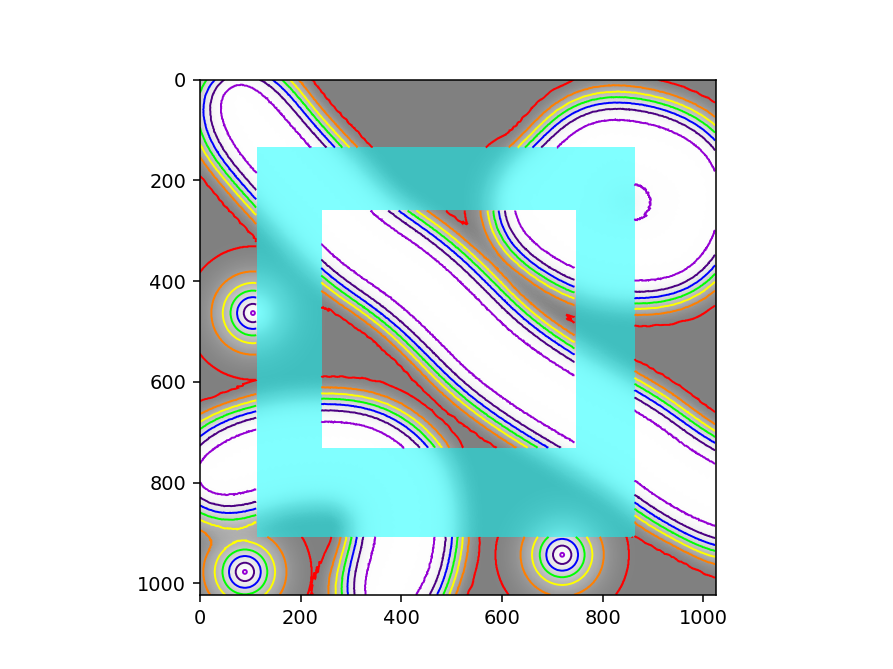

In [31]:
problem = create_test_problem()
marching_square = ThisMarchingSquare(problem.image, problem.mask, use_minmax_cache=True)
plot_problem(problem, marching_square)

WOS detector (700K pixels)
==========================

In [33]:
problem = create_wos_problem()
print("With mask")
marching_square = MarchingSquareSciKitImage(problem.image, problem.mask)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = MarchingSquareCythonArrayOpt(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image, problem.mask)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image, problem.mask, use_minmax_cache=True)
%timeit [marching_square.iso_contour(a) for a in problem.values]
print("Without mask")
marching_square = MarchingSquareSciKitImage(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = MarchingSquareCythonArrayOpt(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image, use_minmax_cache=True)
%timeit [marching_square.iso_contour(a) for a in problem.values]

With mask
485 ms ± 10.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
33.9 ms ± 29.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
16.3 ms ± 894 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
8.74 ms ± 469 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Without mask
131 ms ± 455 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
33.7 ms ± 59 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
29.3 ms ± 1.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
17 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


<IPython.core.display.Javascript object>


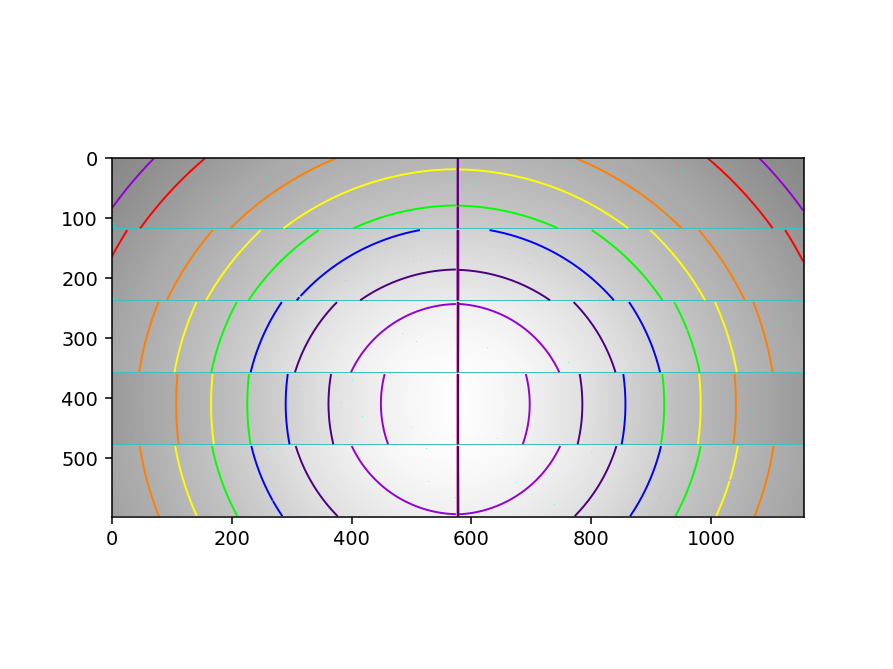

In [41]:
problem = create_wos_problem()
marching_square = ThisMarchingSquare(problem.image, problem.mask, use_minmax_cache=True)
plot_problem(problem, marching_square)

Perkin Elmer (16M pixels)
=========================

In [43]:
problem = create_id22_17_problem()
print("With mask")
marching_square = MarchingSquareSciKitImage(problem.image, problem.mask)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = MarchingSquareCythonArrayOpt(problem.image, problem.mask)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image, problem.mask)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image, problem.mask, use_minmax_cache=True)
%timeit [marching_square.iso_contour(a) for a in problem.values]
print("Without mask")
marching_square = MarchingSquareSciKitImage(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = MarchingSquareCythonArrayOpt(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image, use_minmax_cache=True)
%timeit [marching_square.iso_contour(a) for a in problem.values]

With mask
1.88 s ± 3.58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.65 s ± 4.84 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
274 ms ± 7.11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
28.1 ms ± 3.22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Without mask
1.6 s ± 4.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.24 s ± 8.92 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
224 ms ± 2.35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
26.6 ms ± 5.35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
# On my machine
print("Speed up vs skimage: %s" % (1.61 / 0.215))

Speed up vs skimage: 7.488372093023257


<IPython.core.display.Javascript object>


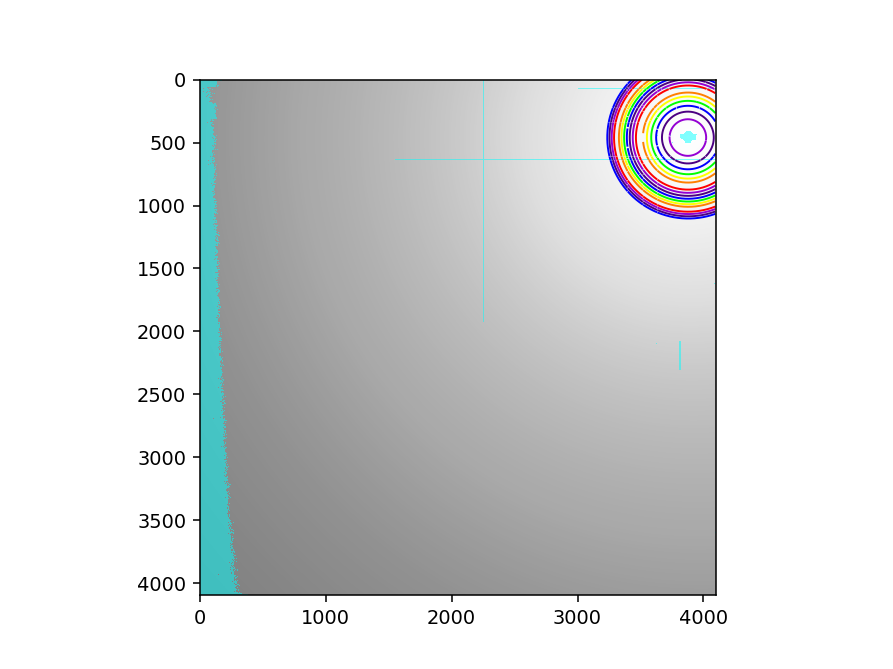

In [42]:
problem = create_id22_17_problem()
marching_square = ThisMarchingSquare(problem.image, problem.mask, use_minmax_cache=True)
plot_problem(problem, marching_square)

<IPython.core.display.Javascript object>


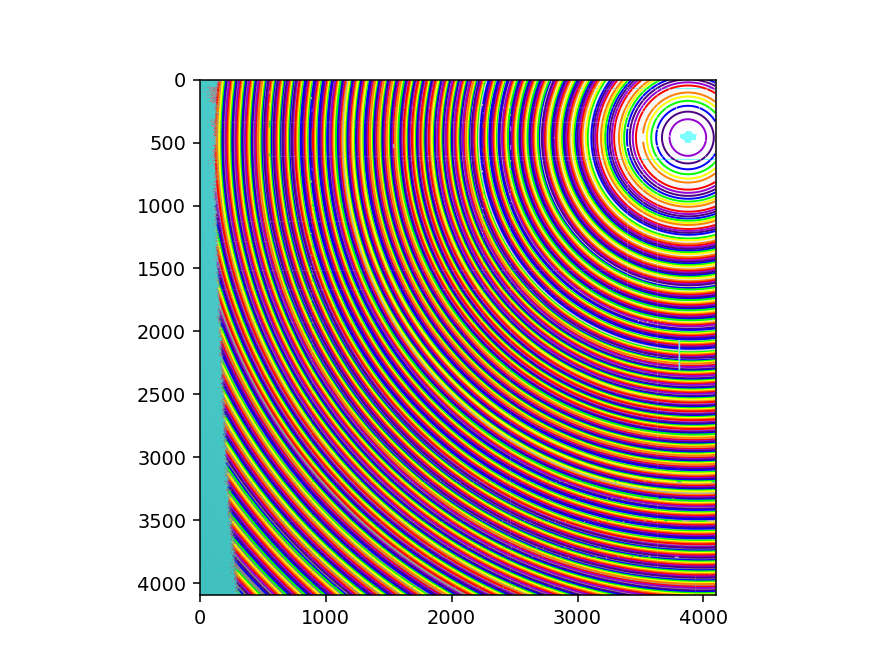

In [44]:
problem = create_id22_1441_problem()
marching_square = ThisMarchingSquare(problem.image, problem.mask, use_minmax_cache=True)
plot_problem(problem, marching_square)

In [46]:
problem = create_id22_1441_problem()
%timeit marching_square = MarchingSquareSciKitImage(problem.image, problem.mask); [marching_square.iso_contour(a) for a in problem.values]
%timeit marching_square = MarchingSquareCythonArrayOpt(problem.image, problem.mask); [marching_square.iso_contour(a) for a in problem.values]
%timeit marching_square = ThisMarchingSquare(problem.image, problem.mask); [marching_square.iso_contour(a) for a in problem.values]
%timeit marching_square = ThisMarchingSquare(problem.image, problem.mask, use_minmax_cache=True); [marching_square.iso_contour(a) for a in problem.values]

52.8 s ± 26.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
38.3 s ± 293 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6.61 s ± 192 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.83 s ± 11.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Check result
============

In [37]:
def create_data(size):
    half = size // 2
    y, x = numpy.ogrid[-half:half, -half:half]
    coef = 1 / half
    y, x = y * coef, x * coef
    data = x*x + y*y
    data = x*x*(x*2) + y*y/2**numpy.sin(y*5)
    data = numpy.sin(data * 6, dtype=numpy.float32)
    return data

def create_test_problem(size=512):
    image = create_data(size)
    values = image.min() + numpy.array(range(10)) * (image.max() - image.min())
    values = values / len(values)
    return Problem(image=image, mask=None, values=values[1:-1])

<IPython.core.display.Javascript object>


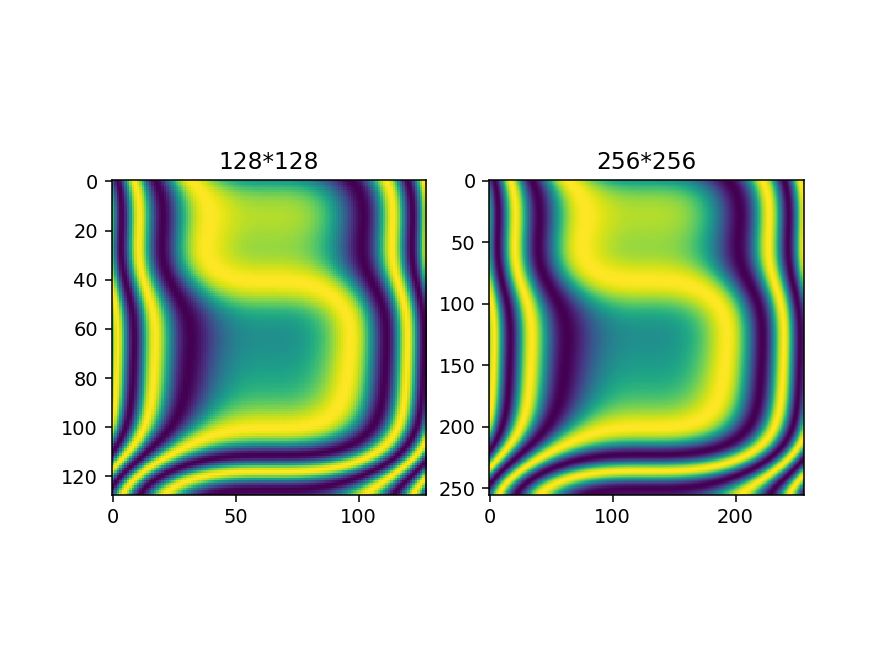

In [38]:
from matplotlib import pyplot
pyplot.figure()
pyplot.subplot(121)
pyplot.title("128*128")
pyplot.imshow(create_data(128))
pyplot.subplot(122)
pyplot.title("256*256")
pyplot.imshow(create_data(256))
pyplot.show()

<IPython.core.display.Javascript object>


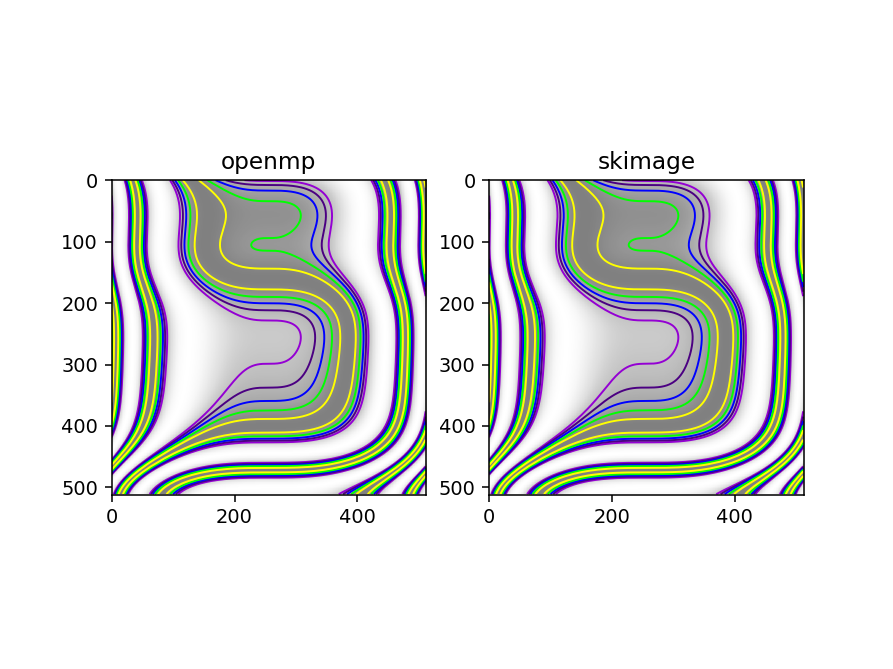

In [39]:
problem = create_test_problem()
pyplot.figure()
pyplot.subplot(121)
pyplot.title("openmp")
marching_square = ThisMarchingSquare(problem.image, problem.mask, use_minmax_cache=True)
imshow_problem(problem, marching_square)
pyplot.subplot(122)
pyplot.title("skimage")
marching_square = MarchingSquareSciKitImage(problem.image, problem.mask)
imshow_problem(problem, marching_square)
pyplot.show()